# Planning TWEAC Setup for Figure-of-Merit Run

## Imports

In [1]:
%pylab inline
import numpy as np
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter
import os
import sys
sys.path.append("/home/s7470087/2019-10_TWEAC-for-Summit/picsrc/lib/python/")
from scipy import constants as sc
from picongpu.utils import MemoryCalculator

Populating the interactive namespace from numpy and matplotlib


## Override Matplotlib Defaults

In [2]:
# OVERWRITE DEFAULT PLOTTING PARAMETERS
params = {
    'font.size' : 20,
    'lines.linewidth' : 3,
    'legend.fontsize' : 20,
    'legend.frameon' : False,
    'legend.numpoints': 1,
    'xtick.labelsize' : 20,
    'ytick.labelsize' : 20,
    'figure.figsize': [12,8],
    'axes.labelsize' : 20
}
mpl.rcParams.update(params)

# Simulation Parameters

## Function definitions

In [3]:
def critical_density_si(lambda_laser):
    """ Critical electron number density at which an 
        incident light wave is reflected from a surface.
        Units [1/m^3]
    """
    return (sc.epsilon_0*sc.m_e/sc.e**2)*(2.*pi*sc.c/lambda_laser)**2

def critical_density(lambda_laser):
    """ Critical electron number density in [1/cm^3]
    """
    return critical_density_si(lambda_laser)*1.e-6

def plasma_angular_frequency(n_e):
    """ 
    """
    return sqrt( n_e * sc.e**2 / ( sc.epsilon_0 * sc.m_e ) )

def plasma_oscillation_length(n_e):
    """ Assuming the driver propagates at the speed of light
    """
    omega_p = plasma_angular_frequency(n_e)
    return 2.*sc.pi*sc.c/omega_p

def debye_length(n_e, T , Z):
    """ electron temperature [T] = eV
        electron density [n_e] = cm^-3
    """
    return 743.*sqrt(T/(1.+Z)/n_e)  # sqrt(epsilon_0*k_B*T/n_e/e_charge**2/(1.+Z))

## Laser parameters

```c++
twtsFieldE1(
    /* focus_y [m], the distance to the laser focus in y-direction */
    30.0e-6,
    /* wavelength [m] */
    0.8e-6,
    /* pulselength [s], sigma of std. gauss for intensity (E^2) */
    10.0e-15 / 2.3548200450309493820231386529194,
    /* w_x [m], cylindrically focused spot size */
    1.2e-6,
    /* w_y [m] */
    0.1,
    /* interaction angle between TWTS laser propagation vector and the y-axis [rad] */
    3.5 * (PI/180.),
    /* propagation speed of overlap [speed of light]. */
    1.0,
    /* manual time delay [s] if auto_tdelay is false */
    50.0e-6 / SI::SPEED_OF_LIGHT_SI,
    /* Should PIConGPU automatically choose a suitable time delay? [true/false] */
    false,
    /* Polarization of TWTS laser field */
    templates::twts::EField::LINEAR_X
),
```

```c++
/** Specify your background field E(r,t) here
*
* \param cellIdx The total cell id counted from the start at t=0
* \param currentStep The current time step */
HDINLINE float3_X
operator()( const DataSpace<simDim>& cellIdx,
        const uint32_t currentStep ) const
{
    
    //
    // Calculation of amplitude
    //

    /* Note: twtsFieldE(...) is normalized, such that peak amplitude equals unity. */
    return    float3_X::create(0.7057829460593135) * amplitude * twtsFieldE1( cellIdx, currentStep )
            - float3_X::create(0.7057829460593135) * amplitude * twtsFieldE2( cellIdx, currentStep )
            + float3_X::create(0.7084281424758874) * amplitude * twtsFieldE3( cellIdx, currentStep )
            + float3_X::create(0.7084281424758874) * amplitude * twtsFieldE4( cellIdx, currentStep );
}
```

In [4]:
# LASER

## Change w_0x to Rayleighlength >~ Plasma oscillation length
## Change pulse duration to tau_FWHM,I = 30fs -> sigma_t,E = tau_FWHM,I / sqrt(2. * log(2.)) / sqrt(2)
## sigma_t,E = tau_FWHM,I / 1.6651 = 18.0168
## lower a0 to just enter the bubble regime

λ_0 = 800e-9 # laser wavelength
print("Laser period = %.1es"%(λ_0/sc.c))

ϕ = 3.5 * sc.pi / 180.
print("ϕ = %.1fdeg"%(ϕ*180./pi))

# beam waist in focus
w_0x = 5.5e-6
print("w_0 = {:.2f} µm".format(w_0x * 1e6))

# Rayleigh length
z_r = 1 * np.pi * w_0x**2 / λ_0
print("z_r = {:.2f} µm".format(z_r * 1e6))

Laser period = 2.7e-15s
ϕ = 3.5deg
w_0 = 5.50 µm
z_r = 118.79 µm


In [5]:
n_c = critical_density(λ_0)*1.e6
print("critical e density for λ_Laser = %.1e/m^3"%(n_c))
print("plasma frequency at critical density = %.1erad/s"%(plasma_angular_frequency(n_c)))
print("plasma period at critical density = %.1es (= laser period)"%(2.*sc.pi/plasma_angular_frequency(n_c)))

critical e density for λ_Laser = 1.7e+27/m^3
plasma frequency at critical density = 2.4e+15rad/s
plasma period at critical density = 2.7e-15s (= laser period)


## Plasma parameters

In [6]:
BASE_DENSITY_SI = 0.8e+23 #0.25e+25 #0.8e+23 # unit: ELEMENTS/m^3
PLATEAU_DENSITY_SI = 2. * BASE_DENSITY_SI

In [7]:
PLASMA_FREQUENCY_SI = plasma_angular_frequency(PLATEAU_DENSITY_SI)
print("plasma frequency at plateau density = %.1erad/s"%(PLASMA_FREQUENCY_SI))
print("plasma period at plateau density = %.1es"%(2.*sc.pi/PLASMA_FREQUENCY_SI))
λ_plasma = plasma_oscillation_length(PLATEAU_DENSITY_SI)
print("plasma oscillation length at plateau density = %.1fmum"%(λ_plasma*1.e6))
print("plasma skin depth = %.1fmum"%(sc.c/PLASMA_FREQUENCY_SI*1.e6))

plasma frequency at plateau density = 2.3e+13rad/s
plasma period at plateau density = 2.8e-13s
plasma oscillation length at plateau density = 83.5mum
plasma skin depth = 13.3mum


In [8]:
λ_plasma_base = plasma_oscillation_length(BASE_DENSITY_SI)
print("plasma frequency at base density = %.1erad/s"%(plasma_angular_frequency(BASE_DENSITY_SI)))
print("plasma oscillation length at base density = %.1fmum"%(λ_plasma_base*1.e6))

plasma frequency at base density = 1.6e+13rad/s
plasma oscillation length at base density = 118.0mum


In [9]:
print("Rayleighlength / plasma oscillation length =", z_r / λ_plasma)
print("Rayleighlength / base plasma oscillation length =", z_r / λ_plasma_base)

Rayleighlength / plasma oscillation length = 1.4231026107584621
Rayleighlength / base plasma oscillation length = 1.0062855063915883


## Mesh parameters

In [10]:
dx_old = 0.6645e-7
dy_old = 0.383649e-7
dz_old = dy_old

n_e_old = 0.25e25 # unit: ELEMENTS/m^3
λ_plasma_old = plasma_oscillation_length(n_e_old)

print("λ_plasma = %.5fμm"%(λ_plasma_old*1.e6))

Lx_old = dx_old*1120
Ly_old = dy_old*2304
Lz_old = dz_old*6144
print("λ_plasma / dx =", λ_plasma / dx_old )
print("λ_Laser / dy =", λ_0 / dy_old )
print("λ_plasma / dz =", λ_plasma / dz_old )
print("x Ausdehnung", Lx_old*1.e6, "μm =", Lx_old / λ_plasma_old, "λ_plasma =", Lx_old / w_0x, "w_0x")
print("y Ausdehnung", Ly_old*1.e6, "μm =", Ly_old / λ_plasma_old, "λ_plasma")
print("z Ausdehnung", Lz_old*1.e6, "μm =", Lz_old / λ_plasma_old, "λ_plasma =", Lz_old / z_r, "z_r")

λ_plasma = 21.11733μm
λ_plasma / dx = 1256.1863328444522
λ_Laser / dy = 20.85239372447211
λ_plasma / dz = 2175.7799920634184
x Ausdehnung 74.424 μm = 3.524308940864691 λ_plasma = 13.531636363636364 w_0x
y Ausdehnung 88.39272960000001 μm = 4.1857907024174335 λ_plasma
z Ausdehnung 235.71394560000002 μm = 11.162108539779823 λ_plasma = 1.9842665572461022 z_r


In [11]:
# box length in y direction, from experience with Piz Daint simulation
L_y = 8. * λ_plasma_base
print("box length in y: {:.2f} µm".format(L_y * 1e6))

# box length in z direction, from experience with Piz Daint simulation (the laser pulse is not bounded in z-direction)
L_z = 15. * z_r
print("box length in z: %.2f µm = %.2f λ_plasma"%(L_z * 1e6, L_z / λ_plasma))

# box length in x direction,
# from the typical criterion for 99% of beam power: pi * w for transversal size
# should fit into the simulation in order to properly model the propagation of the focusing field.
w_init = w_0x * np.sqrt(1 + (.5*L_z / z_r)**2)
print("w_init = {:.2f} µm".format(w_init * 1e6))
print(r"π * w_init = {:.2f} µm".format(np.pi * w_init * 1e6))

# take even more than maybe required from defocusing, also fit two plasma wavelength in the x-direction
L_x = 240.e-6 # m
print("box length in x: {:.2f} µm".format(L_x * 1e6))

box length in y: 944.40 µm
box length in z: 1781.87 µm = 21.35 λ_plasma
w_init = 41.62 µm
π * w_init = 130.74 µm
box length in x: 240.00 µm


### Strict constraints

#### Transverse and longitudinal sampling

In [12]:
## If the projected laser period in the transverse direction is longer than the plasma oscillation length,
## I choose a cell size with equal length in x and z direction.
print("Transverse laser oscillation length / plasma oscillation length =", λ_0 * sin(ϕ) / λ_plasma)

Transverse laser oscillation length / plasma oscillation length = 0.000585081298352031


<span style="color:red;font-size:xlarge;font-face:bold">Vergleiche für Z-Auflösung besser den Fehler der numerischen Group velocity während der propagation durch das Gas (L_cyc/sin(phi)) relativ zur Plasmawellenlaenge und halte es im Promillebereich!</span>

Die numerische Gruppengeschwindigkeit ist gegeben aus der Ableitung der numerischen Phasengeschwindigkeit.
Die numerische Phasengeschwindigkeit wird ermittelt aus der Dispersionsrelation (4.12) im Taflove
$$
  \left [\frac{1}{c\Delta t}\sin\left( \frac{\omega \Delta t}{2} \right) \right]^2 =
      \left [\frac{1}{\Delta x}\sin\left( \frac{k_x \Delta x}{2} \right) \right]^2
      + \left [\frac{1}{\Delta y}\sin\left( \frac{k_y \Delta y}{2} \right) \right]^2
      + \left [\frac{1}{\Delta z}\sin\left( \frac{k_z \Delta z}{2} \right) \right]^2
$$
in dem diese nach $\omega$ aufgelöst wird und 
$$
  v_\mathrm{phase} = \frac{\omega}{k}\,.
$$
Die Gruppengeschwindigkeit ist definiert als
$$
  v_\mathrm{group} = \frac{\partial \omega}{\partial k}\,.
$$
Es gilt
$$
  \frac{\partial}{\partial k} \left[ \frac{1}{c\Delta t} \sin\left( \frac{\omega \Delta t}{2} \right) \right]^2
  = \frac{1}{c^2\Delta t^2} 2 \sin\left( \frac{\omega \Delta t}{2} \right)
    \cos\left( \frac{\omega \Delta t}{2} \right)
    \frac{\Delta t}{2} \frac{\partial \omega}{\partial k}
$$
Deswegen
$$
  \frac{\partial \omega}{\partial k} =
  \frac{c^2\Delta t^2}{ 2 \sin\left( \frac{\omega \Delta t}{2} \right)
    \cos\left( \frac{\omega \Delta t}{2} \right)
    \frac{\Delta t}{2}}
  \frac{\partial}{\partial k} \left[ \frac{1}{c\Delta t} \sin\left( \frac{\omega \Delta t}{2} \right) \right]^2
$$

$$
  \frac{\partial \omega}{\partial k} =
  \frac{c^2\Delta t}{ \sin\left( \frac{\omega \Delta t}{2} \right)
    \cos\left( \frac{\omega \Delta t}{2} \right)
    }
  \frac{\partial}{\partial k} \left[ \frac{1}{c\Delta t} \sin\left( \frac{\omega \Delta t}{2} \right) \right]^2
$$

Dort die rechte Seite der Dispersionsrelation einsetzen und für die karthesischen $k_i$ diese Darstellung für $k$ einsetzen

$$
  (k_x, k_y, k_z) = k ( \sin\vartheta \cos\varphi, \sin\vartheta \sin\varphi, \cos\vartheta)
$$

und ableiten.

Für unsere Propagation in der $y$-$z$-Ebene entlang einer Richtung die einen Winkel von $3.5^\circ$ mit der $y$-Achse einschliesst ist $\varphi = 90^\circ$ und $\vartheta = 86.5^\circ$.

Nutze ausserdem die Relationen 
$$
  S = c\Delta t \sqrt{\frac{1}{\Delta x^2}
                      + \frac{1}{\Delta y^2}
                      + \frac{1}{\Delta z^2}}
    =: \frac{c \Delta t}{\Delta}
  \qquad \text{Courant stabilty factor (Taflove (4.98))}\,,
$$
$$
  \omega \Delta t = \frac{2\pi c \Delta t}{\lambda} 
  = \frac{2 \pi S}{\lambda \sqrt{\frac{1}{\Delta x^2} + \frac{1}{\Delta y^2} + \frac{1}{\Delta z^2}} }
  = 2 \pi S \frac{\Delta}{\lambda}\,.
$$

$$
\sin\left( \frac{\omega \Delta t}{2} \right) =
      c\Delta t
      \sqrt{
      \left [\frac{1}{\Delta x}\sin\left( \frac{k_x \Delta x}{2} \right) \right]^2
      + \left [\frac{1}{\Delta y}\sin\left( \frac{k_y \Delta y}{2} \right) \right]^2
      + \left [\frac{1}{\Delta z}\sin\left( \frac{k_z \Delta z}{2} \right) \right]^2
      }
$$
$$
\frac{\omega \Delta t}{2} =
      \mathrm{Arcsin}\left(
      c\Delta t
      \sqrt{
      \left [\frac{1}{\Delta x}\sin\left( \frac{k_x \Delta x}{2} \right) \right]^2
      + \left [\frac{1}{\Delta y}\sin\left( \frac{k_y \Delta y}{2} \right) \right]^2
      + \left [\frac{1}{\Delta z}\sin\left( \frac{k_z \Delta z}{2} \right) \right]^2
      }
      \right)
$$
$$
\omega =
      \frac{2}{\Delta t}
      \mathrm{Arcsin}\left(
      c\Delta t
      \sqrt{
      \left [\frac{1}{\Delta x}\sin\left( \frac{k_x \Delta x}{2} \right) \right]^2
      + \left [\frac{1}{\Delta y}\sin\left( \frac{k_y \Delta y}{2} \right) \right]^2
      + \left [\frac{1}{\Delta z}\sin\left( \frac{k_z \Delta z}{2} \right) \right]^2
      }
      \right)
$$

Das Ding kann man auch ableiten. Dann unseren Dall mit $k_x = 0$ und $k=2\pi/\lambda_\mathrm{Laser}$ einsetzen und eine interessante Größe in Abhängigkeit von $\Delta z$ auftragen und dann ein passendes $\Delta z$ bestimmen.

Dann noch mit der CFL Bedingung das $\Delta x$ ausrechnen und schauen ob es die Plasmawellenlänge gut auflöst. Oder $\Delta x$ auch noch vorgeben und mit CFL den Zeitschritt ausrechnen.

$$
  \frac{\partial \omega}{\partial k} =
  \frac{c S \Delta}{ \sin\left( \pi S \frac{\Delta}{\lambda} \right)
    \cos\left( \pi S \frac{\Delta}{\lambda} \right)
    }
  \left[ \frac{1}{\Delta x} \sin\left( \pi \sin\vartheta \cos\varphi \frac{\Delta x}{\lambda} \right)
           \cos\left( \pi \sin\vartheta \cos\varphi \frac{\Delta x}{\lambda} \right)
           \sin\vartheta \cos\varphi
         + \frac{1}{\Delta y} \sin\left( \pi \sin\vartheta \sin\varphi \frac{\Delta y}{\lambda} \right)
           \cos\left( \pi \sin\vartheta \sin\varphi \frac{\Delta y}{\lambda} \right)
           \sin\vartheta \sin\varphi
         + \frac{1}{\Delta z} \sin\left( \pi \cos\vartheta \frac{\Delta z}{\lambda} \right)
           \cos\left( \pi \cos\vartheta \frac{\Delta z}{\lambda} \right)
           \cos\vartheta
  \right]
$$

In [13]:
def Delta(Dx, Dy, Dz):
    return 1./np.sqrt(1./Dx**2 + 1./Dy**2 + 1./Dz**2)


def v_g(wavel, theta, phi, Dx, Dy, Dz, S):
    Dd = Delta(Dx, Dy, Dz)
    omega_dt_2 = sc.pi * S * Dd / wavel
    
    arg_ekx = np.sin(theta) * np.cos(phi)
    arg_x = sc.pi * arg_ekx * Dx / wavel
    
    arg_eky = np.sin(theta) * np.sin(phi)
    arg_y = sc.pi * arg_eky * Dy / wavel
    
    arg_ekz = np.cos(theta)
    arg_z = sc.pi * arg_ekz * Dz / wavel
    
    return ( sc.c * S * Dd / ( np.sin(omega_dt_2) * np.cos(omega_dt_2) ) 
             * ( np.sin(arg_x) * np.cos(arg_x) * arg_ekx / Dx
                 + np.sin(arg_y) * np.cos(arg_y) * arg_eky / Dy
                 + np.sin(arg_z) * np.cos(arg_z) * arg_ekz / Dz
               )
           )


#def v_g_phys(λ, a_0, n_e):
#    ''' Aus Esarey RoMP 2009 (?)
#    '''
#    ω_p = plasma_angular_frequency(n_e)
#    ω = 2.*sc.pi*sc.c/λ
#    γ_g = ω / ω_p
#    return np.sqrt( 1. - 1./γ_g**2 ) * sc.c

In [14]:
## The cell length in the longitudinal direction is given by the laser wavelength
dy_strict = λ_0 / 40.
print("dy = {:.5e} m".format(dy_strict))
print("sanity check: longitudinal samples per laser wavelength λ_laser: %.2f"%(λ_0/dy_strict))

dy = 2.00000e-08 m
sanity check: longitudinal samples per laser wavelength λ_laser: 40.00


In [15]:
## The cell length in the transverse directions is given by Courant-Friedrich-Levy condition (eq. (4.98) in Taflove)
## and needs to be much smaller than the plasma oscillation length.
## A large aspect ratio is also not good since we will end up with a lot of particles per cell in the region
## of the accelerated bunch.
## Furthermore, in the sheeth region of the bubble we expect very high density, maybe 1-2 orders of magnitude higher
## than in the base density, and we do not want to model this region completely incorrect.
## Therefore we assume a maximum factor for the aspect ratio.
dx_strict = 8. * dy_strict #λ_plasma / 80.
print("dx = %.5em"%(dx_strict))
print("Samples per plasma oscillation length λ_p = 2πc/ω_p: %.2f"%(λ_plasma/dx_strict))

dx = 1.60000e-07m
Samples per plasma oscillation length λ_p = 2πc/ω_p: 521.71


In [16]:
## Define Courant factor S and laser strength a_0 for Dz determination
S = 0.995
print("ϕ = %.1fdeg"%(ϕ*180./pi))
theta = .5 * sc.pi - ϕ
print("theta = %.1fdeg"%(theta*180./pi))
phi = .5 * sc.pi
print("phi = %.1fdeg"%(phi*180./pi))
a_0 = 3.0

dz = np.linspace(dy_strict, 5.*dx_strict, 500)

ϕ = 3.5deg
theta = 86.5deg
phi = 90.0deg


In [17]:
print("dz[0] / dy =", dz[0] / dy_strict)
print("numerical group velocity v_g / c = %.8f"%(v_g(λ_0, theta, phi, dx_strict, dy_strict, dz[0], S)/sc.c))
print("physical group velocity error Δv_g / c = %.8f"%(v_g(λ_0, theta, phi, dx_strict, dy_strict, dz[0], S)/sc.c - 1.))

dz[0] / dy = 1.0
numerical group velocity v_g / c = 0.99793771
physical group velocity error Δv_g / c = -0.00206229


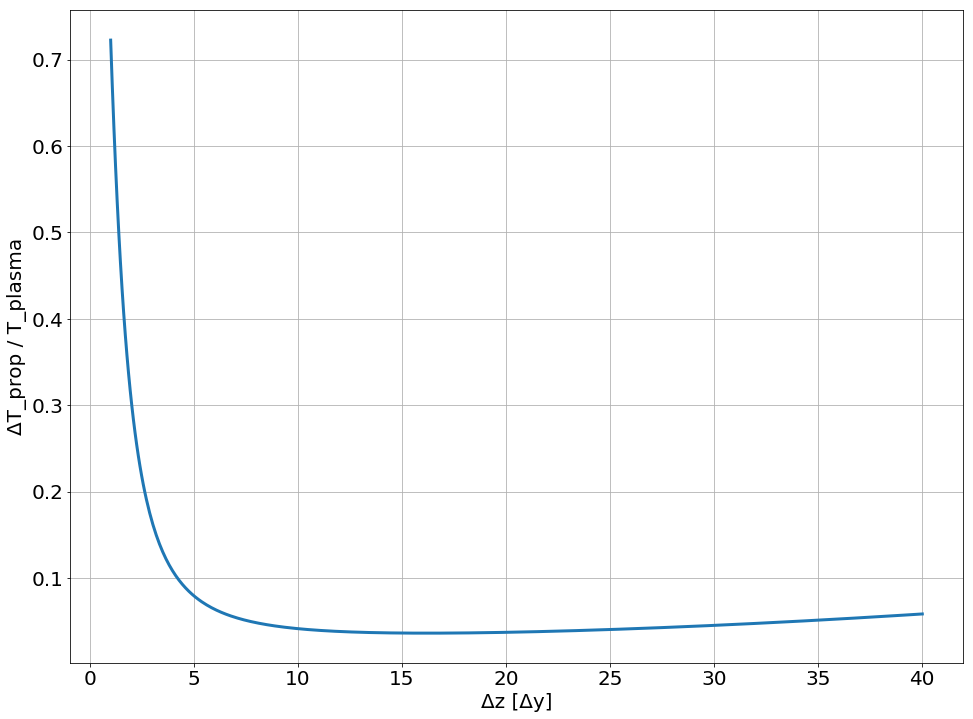

In [18]:
ΔT_prop = L_z / np.sin(ϕ) * ( 1./v_g(λ_0, theta, phi, dx_strict, dy_strict, dz, S) - 1./sc.c)
T_plasma = 2.*sc.pi/PLASMA_FREQUENCY_SI

figure(figsize=(16,12))

plot(dz/dy_strict, ΔT_prop / T_plasma)

xlabel("Δz [Δy]")
ylabel("ΔT_prop / T_plasma")

#xticks(np.arange(0., dz[-1] / dy_strict, 2))

#xlim(0,50)

grid()

show()

There is a minimum in the physical group-velocity error $\Delta v_\mathrm{g}$!

In [19]:
dz_min = np.argmin(ΔT_prop / T_plasma)
print("Minimum at %i: Dz = %i Dy"%(dz_min, dz[dz_min]/dy_strict))

Minimum at 194: Dz = 16 Dy


In [20]:
## Choose dz to have the numerical group velocity error at a minimum
dz_strict = 8.*dy_strict

#### Temporal sampling

In [21]:
## Calculate the time sampling from the CFL condition
dt_strict = S * Delta(dx_strict, dy_strict, dz_strict) / sc.c

In [22]:
print("sanity check: temporal samples per laser period λ_Laser / c Δt =", λ_0 / sc.c / dt_strict)
print("sanity check: Δy / c Δt =", dy_strict / sc.c / dt_strict)
print("sanity check CFL condition: c Δt =", sc.c * dt_strict, "<", 1./sqrt( 1./dx_strict**2 + 1./dy_strict**2 + 1./dz_strict**2 ), "!?")

sanity check: temporal samples per laser period λ_Laser / c Δt = 40.82431359113547
sanity check: Δy / c Δt = 1.0206078397783866
sanity check CFL condition: c Δt = 1.9596165363909774e-08 < 1.969463855669324e-08 !?


In [23]:
print("Summary of sampling parameters")
print("==============================")
print("dt = %.5es = %.3f T_Laser = %.1e T_Plasma"%(dt_strict, dt_strict/(λ_0 / sc.c), dt_strict/(2. * sc.pi / PLASMA_FREQUENCY_SI)))
print("dx = %.5em = %.3f λ_Laser = %.1e λ_Plasma"%(dx_strict, dx_strict/λ_0, dx_strict/λ_plasma_base))
print("dy = %.5em = %.3f λ_Laser = %.1e λ_Plasma"%(dy_strict, dy_strict/λ_0, dy_strict/λ_plasma_base))
print("dz = %.5em = %.3f λ_Laser = %.1e λ_Plasma"%(dz_strict, dz_strict/λ_0, dz_strict/λ_plasma_base))

Summary of sampling parameters
dt = 6.53658e-17s = 0.024 T_Laser = 2.3e-04 T_Plasma
dx = 1.60000e-07m = 0.200 λ_Laser = 1.4e-03 λ_Plasma
dy = 2.00000e-08m = 0.025 λ_Laser = 1.7e-04 λ_Plasma
dz = 1.60000e-07m = 0.200 λ_Laser = 1.4e-03 λ_Plasma


In [24]:
print("Typical particles per cell =", BASE_DENSITY_SI * dx_strict * dy_strict * dz_strict)

Typical particles per cell = 40.96


### Simulation window volume

In [25]:
box_cells_x_raw = np.int(L_x / dx_strict)
print("box L_x: ",box_cells_x_raw)
box_cells_y_raw = np.int(L_y / dy_strict)
print("box L_y: ",box_cells_y_raw)
box_cells_z_raw = np.int(L_z / dz_strict)
print("box L_z: ",box_cells_z_raw)

cells_norm = box_cells_x_raw
print("Ratio of box dimensions [cells] : x : y : z = %.1f : %.1f : %.1f"%(box_cells_x_raw/cells_norm, box_cells_y_raw/cells_norm, box_cells_z_raw/cells_norm))

box L_x:  1500
box L_y:  47219
box L_z:  11136
Ratio of box dimensions [cells] : x : y : z = 1.0 : 31.5 : 7.4


### Calculate the real number of cells in the box

Aim for a simulation volume per GPU that has an approximately even number of cells in all directions.

Berechne Verhältnis der Boxlängen zueinander und nimm selbes Verhältnis für Verteilung der Grafikkarten.

#### Estimate GPU distribution from ratio of box dimensions

In [26]:
# domain decomposition
n_scale = 4.7
gpus_x_raw = 1 * n_scale
gpus_y_raw = 32 * n_scale
gpus_z_raw = 8. * n_scale

print("GPUs raw x : y : z = %.1f : %.1f : %.1f"%(gpus_x_raw, gpus_y_raw, gpus_z_raw))
print("total number of gpus raw:", gpus_x_raw * gpus_y_raw * gpus_z_raw)

GPUs raw x : y : z = 4.7 : 150.4 : 37.6
total number of gpus raw: 26578.688000000006


#### Calculate GPU distribution

In [27]:
## Set number of GPUs in one direction 
gpus_total = 27600.
gpus_i = 5. 

gpus_remain = gpus_total / gpus_i
print(gpus_remain)

5520.0


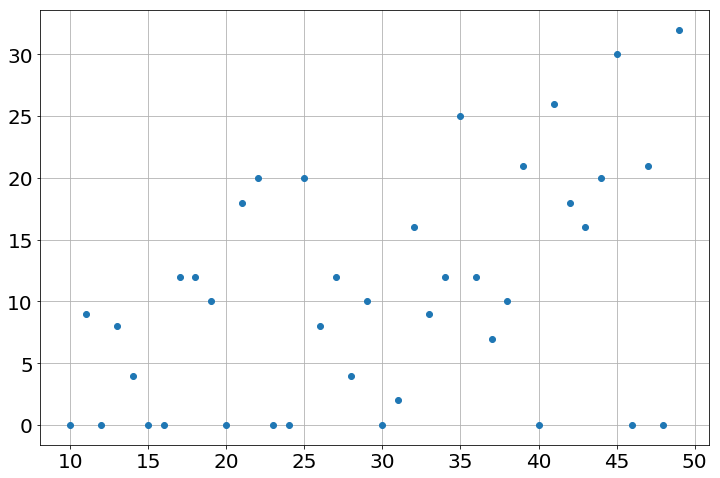

In [28]:
## Acceptable range of GPUs in the second direction
gpus_j_array = np.arange(10, 50, dtype=float)

## Plot the remainder of gpus_remain / gpus_j in order to find integral divisors
## which result in an integral number of GPUs in the third direction
figure()

plot(gpus_j_array, gpus_remain%gpus_j_array, 'o')

grid()

show()

In [29]:
gpus_j = 40.
print(gpus_j)
gpus_k = gpus_remain / gpus_j
print(gpus_k)

40.0
138.0


In [30]:
# domain decomposition
gpus_x = gpus_i
gpus_y = gpus_k
gpus_z = gpus_j

print("GPUs x : y : z = %.1f : %.1f : %.1f"%(gpus_x, gpus_y, gpus_z))
print("total number of gpus:", gpus_x * gpus_y * gpus_z)

# super cell
super_cell = np.array([8, 8, 4])

#box_raw = np.array([box_cells_x_raw, box_cells_y_raw, box_cells_z_raw])
## Scale to smaller volume for Summit
box_raw = np.array([box_cells_x_raw, box_cells_y_raw, box_cells_z_raw]) / 2**(1./3.)
gpu_raw = np.array([box_raw[0] / gpus_x / super_cell[0]
                    , box_raw[1] / gpus_y / super_cell[1]
                    , box_raw[2] / gpus_z / super_cell[2]])

print("simulation box size raw =", box_raw)
print("super cells per gpu:", gpu_raw)

GPUs x : y : z = 5.0 : 138.0 : 40.0
total number of gpus: 27600.0
simulation box size raw = [ 1190.55078898 37477.74513644  8838.64905736]
super cells per gpu: [29.76376972 33.94723291 55.24155661]


In [31]:
box_cells_x = 30. * gpus_x * super_cell[0]
box_cells_y = 34. * gpus_y * super_cell[1]
box_cells_z = 56. * gpus_z * super_cell[2]

box = np.array([box_cells_x, box_cells_y, box_cells_z])
print("Simulation box size = ", box)
print("box dimesion per gpu (x, y, z) [cells] = (%.1f, %.1f, %.1f)"%(box_cells_x / gpus_x, box_cells_y / gpus_y, box_cells_z / gpus_z))

Simulation box size =  [ 1200. 37536.  8960.]
box dimesion per gpu (x, y, z) [cells] = (240.0, 272.0, 224.0)


## Estimate memory consumption

In [32]:
# typical number of particles per cell
N_PPC = 25.

print("Number of particles = %.5e"%(box[0]*box[1]*box[2]*N_PPC))

Number of particles = 1.00897e+13


In [33]:
n_x = np.int(box_cells_x / gpus_x)
n_y = np.int(box_cells_y / gpus_y)
n_z = np.int(box_cells_z / gpus_z)

mc = MemoryCalculator(
    n_x=n_x,
    n_y=n_y,
    n_z=n_z,
    precision_bits=32
)

In [34]:
print("Memory requirement per GPU:")
# field memory per GPU
field_gpu = mc.mem_req_by_fields(field_tmp_slots=2,particle_shape_order=3,sim_dim=3)
print("+ fields: {:.2f} MB".format(
    field_gpu / (1024 * 1024)))
# particle memory per GPU - only the target area contributes here
e_gpu = mc.mem_req_by_particles(
    n_x, n_y, n_z, num_additional_attributes = 0,
    particles_per_cell = N_PPC)

# memory for calorimeters
cal_gpu = mc.mem_req_by_calorimeter(n_energy=1024, n_yaw=180, n_pitch=90
                                     )

print("+ species:")
print("- e: {:.2f} MB".format(e_gpu / (1024 * 1024)))

rng_gpu = mc.mem_req_by_rng(n_x, n_y, n_z)
print("+ RNG states: {:.2f} MB".format(rng_gpu / (1024 * 1024)))

print("+ particle calorimeters: {:.2f} MB".format(cal_gpu / (1024 * 1024)))

mem_sum = field_gpu + e_gpu + rng_gpu + cal_gpu
print("Sum of required GPU memory: {:.2f} MB".format(mem_sum / (1024 * 1024)))

Memory requirement per GPU:
+ fields: 740.68 MB
+ species:
- e: 10807.62 MB
+ RNG states: 334.69 MB
+ particle calorimeters: 126.56 MB
Sum of required GPU memory: 12009.55 MB


**Available clusters**

* taurus: *gpu2* partition: 256 x Tesla **k80 with 11441MiB memory**
* taurus: *ml* partition: 132 x Tesla **V100 with 32256MiB memory**
* Summit: ** partition: 27648 Nvidia Tesla **V100 with 16130MiB memory** (4608 nodes, in total 9216 IBM POWER9 CPUs and 27648 Nvidia Tesla GPUs)

# Creating the example 

Branch: `topic-2019-10_TWEAC-for-Summit_0.4.3dev`

## `grid.param`

In [35]:
print("dt = {:.5e} s".format(dt_strict))
print("dx = {:.5e} m".format(dx_strict))
print("dy = {:.5e} m".format(dy_strict))
print("dz = {:.5e} m".format(dz_strict))

dt = 6.53658e-17 s
dx = 1.60000e-07 m
dy = 2.00000e-08 m
dz = 1.60000e-07 m


### Set the correct move point for the moving window
<span style="font-weight:bold; font-size:xx-large; color:coral">TODO</span>

Depends on simulation window size (take into account that there is on row of GPUs less for moving window simulations), as well as `time_delay` and `focus_y` in `fieldBackground.param`.

## `fieldSolver.param`


```C++
    using CurrentInterpolation = currentInterpolation::Binomial;
    using Solver = maxwellSolver::Yee< CurrentInterpolation >;
```

## `density.param`

## Gas profiles

In [152]:
def richard_density(y, z):
    CELL_WIDTH_SI = dx_strict
    CELL_HEIGHT_SI = dy_strict
    CELL_DEPTH_SI = dz_strict
    
    VACUUM_Y_SI = 100.0 * CELL_HEIGHT_SI
    VACUUM_Z_SI = 148.0 * CELL_DEPTH_SI
    Z_GRADIENT_SI = 32.0 * CELL_DEPTH_SI

    SIM_BOX_Z = box[2] * CELL_DEPTH_SI # MATCH THIS WITH Z-COMPONENT OF "TBG_gridsize" IN CFG_FILE !!!                                                              
    
    PLASMA_Z_LENGTH_SI = SIM_BOX_Z - 2.0 * VACUUM_Z_SI
    
    INITIAL_UPRAMP = 0.0e-6 ##change
    LOW_DENSITY_PLATEAU = 0.0e-6 ##change
    TORCH_UPRAMP = 120.0e-6 ##change
    HIGH_DENSITY_PLATEAU = 240.0e-6 ##change
    DOWNRAMP_1 = 15.0e-6 ##change
    DOWNRAMP_2 = 0.0e-6 ##change
    
    REL_DENSITY_LOW = 0.0
    REL_DENSITY_HIGH = 2.0
    REL_DENSITY_MEDIUM = 1.0 #sqrt(2.0)
    REL_DENSITY_BASE = 1.0 # always one, use BASE_DENSITY_SI to change base density
                           # just here to avoid "magic" 1.0s in the code
    
    REL_DENSITY = REL_DENSITY_BASE
    
    
    # Plot of density profile                                                                  
    #
    #   density                                                                                  
    #
    # REL_DENSITY_HIGH   |        ___                                                                              
    # REL_DENSITY_MEDIUM |       /   \                                                                             
    # REL_DENSITY_LOW    |    __/     `.                                                                           
    # REL_DENSITY_BASE   |   /          `._______                                                                  
    #                    |  /                                                                                    
    #                    |----------------------------  y                                                       
    #                      A B C D E  F  G   H                                                                   
    # */
    
    
    # vacuum before gas (A)                                                                    
    if ( y < VACUUM_Y_SI ):
        return 0.0
    if ( z < VACUUM_Z_SI or z >= (PLASMA_Z_LENGTH_SI + VACUUM_Z_SI ) ):
        REL_DENSITY = 0.0
    if ( z >= VACUUM_Z_SI and z < ( VACUUM_Z_SI + Z_GRADIENT_SI ) ):
        REL_DENSITY =  (z - VACUUM_Z_SI ) / Z_GRADIENT_SI
    if ( z < ( PLASMA_Z_LENGTH_SI + VACUUM_Z_SI ) and z >= ( PLASMA_Z_LENGTH_SI + VACUUM_Z_SI - Z_GRADIENT_SI ) ):
        REL_DENSITY = ( PLASMA_Z_LENGTH_SI + VACUUM_Z_SI - z) / Z_GRADIENT_SI
    
    # first up-ramp (B)
    y_B = VACUUM_Y_SI + INITIAL_UPRAMP
    if ( y >= ( VACUUM_Y_SI ) and y < y_B ):
        return REL_DENSITY * REL_DENSITY_LOW * ( ( y - VACUUM_Y_SI ) / INITIAL_UPRAMP )
    
    # first plateau (C)
    y_C = y_B + LOW_DENSITY_PLATEAU
    if ( y >= y_B and y < y_C ):
        return REL_DENSITY * REL_DENSITY_LOW
    
    # second up-ramp (D)
    y_D = y_C + TORCH_UPRAMP
    if ( y >= y_C and y < y_D ):
        return REL_DENSITY * (REL_DENSITY_HIGH - REL_DENSITY_LOW) * ( ( y - y_C ) / TORCH_UPRAMP ) + REL_DENSITY_LOW
    
    # second plateau (E)
    y_E = y_D + HIGH_DENSITY_PLATEAU
    if ( y >= y_D and y < y_E ):
        return REL_DENSITY * REL_DENSITY_HIGH
    
    # first down-ramp (F)
    y_F = y_E + DOWNRAMP_1
    if ( y >= y_E and y < y_F ):
        return REL_DENSITY * (REL_DENSITY_MEDIUM - REL_DENSITY_HIGH) * ( y - y_E ) / DOWNRAMP_1 + REL_DENSITY * REL_DENSITY_HIGH

    # second down-ramp (G)
    y_G = y_F + DOWNRAMP_2
    if ( y >= y_F and y < y_G ):
        return REL_DENSITY * ( REL_DENSITY_BASE - REL_DENSITY_MEDIUM ) * ( y - y_F ) / DOWNRAMP_2 + REL_DENSITY * REL_DENSITY_MEDIUM
        
    # third plateau (H)
    if ( y >= y_G):
        return REL_DENSITY * REL_DENSITY_BASE # 0.32+e19 cm^-3                                         

    return (REL_DENSITY * REL_DENSITY_BASE)

In [153]:
def density_from_array(y,z):
    """ since the density profile functions above only work fpr single (y,z)-pairs
        this wrapper function allows to calculate the density in a (y,z)-plane from
        arrays of y- and z-values.
        
        NOTE: Adjust the density you want to plot by using the respective function in
        the line starting with `density[j,i] = ...`
    """
    density = zeros((len(z),len(y)))
    #print(shape(density))
    j=0
    for z_j in z:
        i=0
        for y_i in y:
            density[j,i] = richard_density(y_i, z_j) ## linear increase: 10.*y_i #2.*z_j 
                                                     ## Alex original: alex_density(y_i, z_j)
            #print(j,i)
            #print(y_i,z_j)
            i+=1
        j+=1
    
    return density

In [154]:
y = np.linspace(0., 400.e-6, 200)
z = np.linspace(0., box[2]*dz_strict, 200)
density2d = density_from_array(y,z)

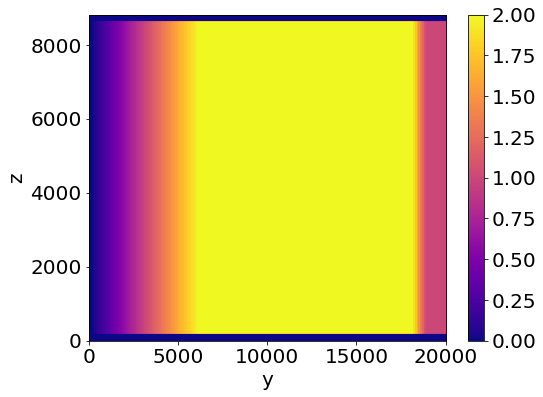

In [156]:
figure(figsize=((8,6)))

imshow(density2d
       #, extent=(y[0]*1.e6, y[-1]*1.e6, z[0]*1.e6, z[-1]*1.e6)
       , extent=(y[0]/dy_strict, y[-1]/dy_strict, z[0]/dz_strict, z[-1]/dz_strict)
       , interpolation='none'
       , origin='lower'
       #, vmin = , vmax = 
       , cmap=cm.plasma
       , aspect='auto'
)

xlabel(r"y")
ylabel(r"z")

colorbar()

show()

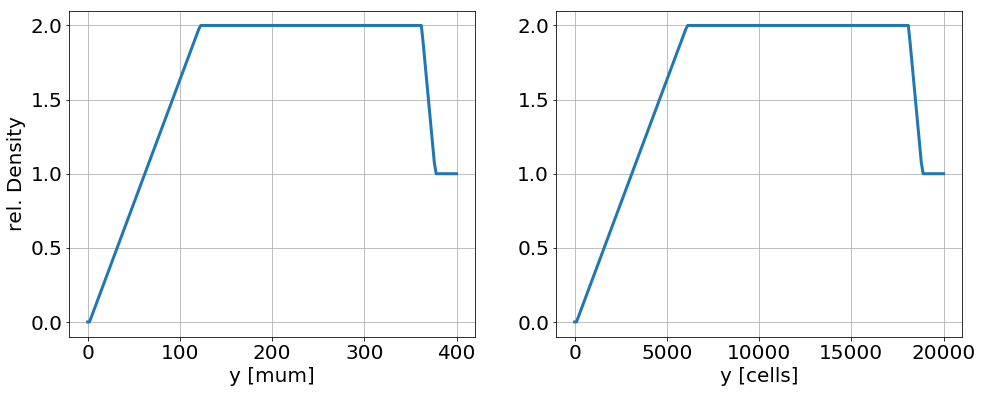

In [157]:
figure((figsize(16,6)))
subplot(1,2,1)

plot(y*1.e6, density2d[len(z)//2,:])

xlabel("y [mum]")
#xlim(0,500)
#xticks(arange(0,501,25))

ylabel("rel. Density")
grid()


subplot(1,2,2)
plot(y/dy_strict, density2d[len(z)//2,:])
xlabel("y [cells]")
grid()

show()

## `species.param`

```C++
    using UsedParticleShape = particles::shapes::PCS;

    using UsedParticleCurrentSolver = currentSolver::EmZ< UsedParticleShape >;

    using UsedParticlePusher = particles::pusher::Vay;
```

## `speciesDefinition.param`

Deleted everything except electrons.

## `particle.param`

Adjust minimum weighting and numbers of particles per cell.

```C++
    /** a particle with a weighting below MIN_WEIGHTING will not
     *      be created / will be deleted
     *
     *  unit: none */
    constexpr float_X MIN_WEIGHTING = 0.001;

    /** Number of maximum particles per cell during density profile evaluation.
     *
     * Determines the weighting of a macro particle and with it, the number of
     * particles "sampling" dynamics in phase space.
     */
    constexpr uint32_t TYPICAL_PARTICLES_PER_CELL = 25u;

```

In [38]:
print("current TYPICAL_PARTICLES_PER_CELL =", N_PPC)

current TYPICAL_PARTICLES_PER_CELL = 25.0


## `particleFilters.param`

Added something according to old run on Piz Daint.

## `speciesInitialization.param`

Set density profile, start position, add drift and temperature.

```C++
using InitPipeline = bmpl::vector<
        CreateDensity<
            densityProfiles::FreeFormula,
            startPosition::Random,
            PIC_Electrons
        >,
        Manipulate<
            manipulators::AssignYDriftPositive,
            PIC_Electrons
        >,
        Manipulate<
            manipulators::AddTemperature,
            PIC_Electrons
        >
    >;
```

## `memory.param`

Increase default exchange memory.
```C++
    struct DefaultExchangeMemCfg
    {
        // memory used for a direction
        static constexpr uint32_t BYTES_EXCHANGE_X = 6 * 1024 * 1024; // 6 MiB
        static constexpr uint32_t BYTES_EXCHANGE_Y = 96 * 1024 * 1024; // 96 MiB
        static constexpr uint32_t BYTES_EXCHANGE_Z = 6 * 1024 * 1024; // 6 MiB
        static constexpr uint32_t BYTES_EDGES = 256 * 1024; // 256 kiB
        static constexpr uint32_t BYTES_CORNER = 64 * 1024; // 64 kiB
    };

```

## `fieldbackground.param`
Add 4 TWTS pulses per field (E, B) in order to generate 2 pulse-front titled laser pulses with crossed polarization.
The polarization direction calculations for the individual pulses was done by @beyondEspresso.

### E-Field
```C++
    // Parameters of a single TWTS pulse
    twtsFieldE1(
        /* focus_y [m], the distance to the laser focus in y-direction */
        30.0e-6,
        /* wavelength [m] */
        0.8e-6,
        /* pulselength [s], sigma of std. gauss for intensity (E^2) */
        10.0e-15 / 2.3548200450309493820231386529194,
        /* w_x [m], cylindrically focused spot size */
        1.2e-6,
        /* w_y [m] */
        0.1,
        /* interaction angle between TWTS laser propagation vector and the y-axis [rad] */
        3.5 * (PI/180.),
        /* propagation speed of overlap [speed of light]. */
        1.0,
        /* manual time delay [s] if auto_tdelay is false */
        50.0e-6 / SI::SPEED_OF_LIGHT_SI,
        /* Should PIConGPU automatically choose a suitable time delay? [true/false] */
        false,
        /* Polarization of TWTS laser field */
        templates::twts::EField::LINEAR_X ),
```
`twtsFieldE2` has an interaction angle of `- 3.5 * (PI/180.)`.

`twtsFieldE3` has polarization `templates::twts::EField::LINEAR_YZ`.

`twtsFieldE4` has polarization `templates::twts::EField::LINEAR_YZ` and interaction angle of `- 3.5 * (PI/180.)`.


In
```C++
    HDINLINE float3_X operator()( const DataSpace<simDim>& cellIdx, const uint32_t currentStep ) const
```
The wavelength definition appears again (<span style="font-size:xx-large; font-weight:bold; color:coral">Why?</span>)
```C++
    constexpr float_64 WAVE_LENGTH_SI = 0.8e-6;
```
And later in that function
```C++
    const float_64 _A0  = 3.25 * 0.01; //reduced for FOM benchmark
```

### B-Field
Exactly the same as E-Field

## `png.param`

Change channel settings
```
    /* png preview settings for each channel */
    DINLINE float_X preChannel1(const float3_X& field_B, const float3_X& field_E, const float3_X& field_J)
    {
        return math::abs2(field_J);
    }

    DINLINE float_X preChannel2(const float3_X& field_B, const float3_X& field_E, const float3_X& field_J)
    {
        return field_E.x() * field_E.x() + field_E.y() * field_E.y() + field_E.z() * field_E.z();
    }
 
    DINLINE float_X preChannel3(const float3_X& field_B, const float3_X& field_E, const float3_X& field_J)
    {
       return -1.0_X * field_E.y();
    }

```

<span style="font-size:xx-large; font-weight:bold; color:coral">What about?</span>

```C++
    constexpr float_64 scale_image = 1./64.;
```

# Config files

### FOM run

Only:
* periodic boundary condition
* macroparticle counter